In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchvision, torch

In [41]:
import sys, os
sys.path.insert(0,"../torchxrayvision/")
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import glob
import numpy as np
import skimage, skimage.filters
%matplotlib inline
import captum, captum.attr
import torch, torch.nn
import pickle
import attribution
import pandas as pd
import datasets
import shutil
import json
import glob
from scipy.ndimage import measurements as s_ndi_m

In [4]:
dmerge = datasets.get_data("nih")

NIH_Dataset num_samples=67310 views=['PA'] data_aug=None


In [5]:
dmerge

{'Atelectasis': {0.0: 61582, 1.0: 5728},
 'Cardiomegaly': {0.0: 65747, 1.0: 1563},
 'Consolidation': {0.0: 65789, 1.0: 1521},
 'Edema': {0.0: 67034, 1.0: 276},
 'Effusion': {0.0: 60721, 1.0: 6589},
 'Emphysema': {0.0: 65811, 1.0: 1499},
 'Fibrosis': {0.0: 65902, 1.0: 1408},
 'Hernia': {0.0: 67118, 1.0: 192},
 'Infiltration': {0.0: 57957, 1.0: 9353},
 'Mass': {0.0: 63743, 1.0: 3567},
 'Nodule': {0.0: 63133, 1.0: 4177},
 'Pleural_Thickening': {0.0: 64892, 1.0: 2418},
 'Pneumonia': {0.0: 66680, 1.0: 630},
 'Pneumothorax': {0.0: 63903, 1.0: 3407}}


NIH_Dataset num_samples=67310 views=['PA'] data_aug=None

In [6]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic").cuda()

In [7]:
models = [xrv.models.DenseNet(weights="all").cuda(),
          xrv.baseline_models.jfhealthcare.DenseNet().cuda()]

In [8]:
model = models[0]
print(model.pathologies)
print(model)

['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']
XRV-DenseNet121-all


In [9]:
for_eval = [
            "Cardiomegaly",
            "Atelectasis",
            "Effusion",
            "Consolidation",
            "Edema",
            "Mass"
            ]

In [10]:
model.pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [11]:
for_eval

['Cardiomegaly', 'Atelectasis', 'Effusion', 'Consolidation', 'Edema', 'Mass']

In [12]:
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
temp_path = "/carl/rupert_brooks/output/temp"

tensor([0.5100])
[0.44826764] -370 20
Thresholding at 0.18152104591836735
Thresholding at 0.18152104591836735
Thresholding at 0.18152104591836735
Thresholding at 0.18152104591836735


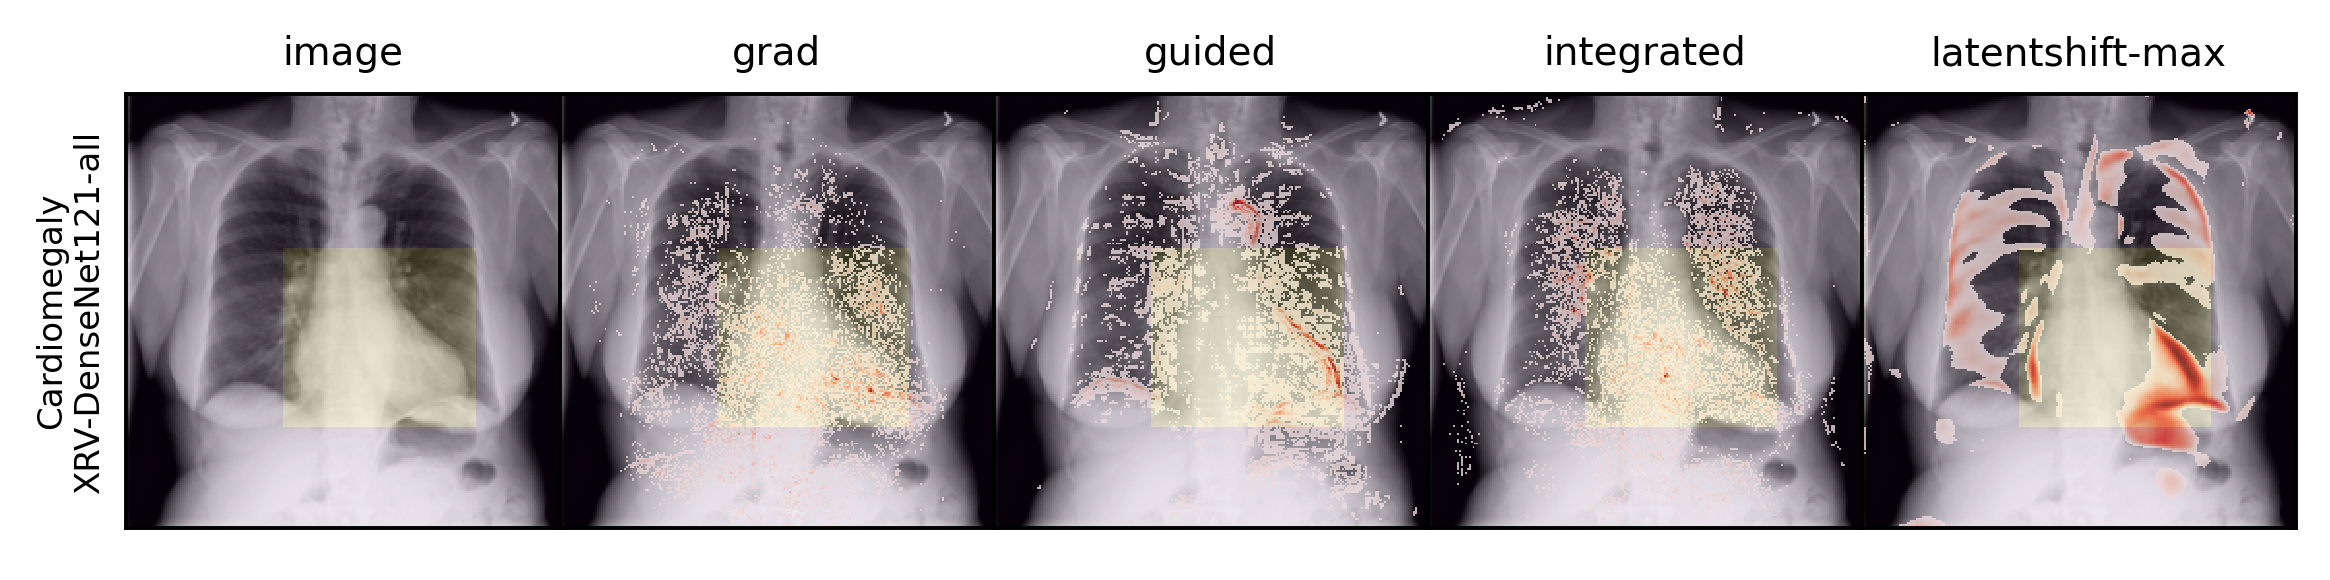

In [67]:
target = "Cardiomegaly"
label = 1
dwhere = np.where(dmerge.csv.has_masks & (dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
idx = 5
sample = dmerge[dwhere[idx]]
model = models[0]
saliency_maps=attribution.generate_attributions(sample, model, target, ae, temp_path, dmerge)

In [109]:
def centroid_and_size(component):
    centroid=np.mean(component, axis=1)
    sz=len(component[0])
    return centroid,sz

mask=dmerge[dwhere[idx]]['pathology_masks'][dmerge.pathologies.index(target)].squeeze()
mask_components, mask_ncomponents = s_ndi_m.label(mask)
centroids_and_sizes_mask=[centroid_and_size(np.where(mask_components==i)) for i in range(1,1+mask_ncomponents)]
smap_components=dict()
for k,smap in saliency_maps.items():
    smap_c, n_c=s_ndi_m.label(attribution.thresholdf(smap,95)>0)
    centroids_and_sizes=[centroid_and_size(np.where(smap_c==i)) for i in range(1,1+n_c)]
    smap_components[k]=(smap_c,n_c,centroids_and_sizes)
    total_weight=0
    weighted_sum=0
    for ctr,sz in centroids_and_sizes:
        mindist=np.inf
        for ctr_mask,sz_mask in centroids_and_sizes_mask:
            d1=np.sqrt(np.sum(np.square(ctr_mask-ctr)))
            mindist=np.min([mindist,d1])
        weighted_sum+=mindist*sz
        total_weight+=sz
    print('Avg dist (pixels)',weighted_sum/total_weight)
    print(k,"n components",smap_components[k][1])


Avg dist (pixels) 46.2047089448022
grad n components 762
Avg dist (pixels) 50.768992527452475
guided n components 239
Avg dist (pixels) 46.214776334212296
integrated n components 744
Avg dist (pixels) 57.71517570486643
latentshift-max n components 25


In [134]:
class CentroidDistanceCalculator:
    def __init__(self,mask):
        self.mask_components, self.mask_ncomponents = s_ndi_m.label(mask>0)
        self.mask_centroids=[centroid_and_size(np.where(self.mask_components==i))[0] 
                             for i in range(1,1+self.mask_ncomponents)]
    def compute_weighted_average_distance(self,thresholded_mask):
        smap_c, n_c=s_ndi_m.label(thresholded_mask)
        centroids_and_sizes=[centroid_and_size(np.where(smap_c==i)) for i in range(1,1+n_c)]
        total_weight=0
        weighted_sum=0
        for ctr,sz in centroids_and_sizes:
            mindist=np.inf
            for ctr_mask in self.mask_centroids:
                d1=np.sqrt(np.sum(np.square(ctr_mask-ctr)))
                mindist=np.min([mindist,d1])
            weighted_sum+=mindist*sz
            total_weight+=sz
        return weighted_sum/total_weight

def unit_test_1():
    gt=np.zeros((100,100))
    gt[25:50,25:50]=1
    gt[55:76,55:76]=1
    pred=np.zeros((100,100))
    pred[25,25]=1
    pred[45,65]=1
    # hand calc
    # dists (12,12)->16.971, (60,60)
    # dists (8,28), (20,0)->20
    cdc=CentroidDistanceCalculator(gt)
    print(cdc.compute_weighted_average_distance(pred))
    assert(np.abs(cdc.compute_weighted_average_distance(pred)-(16.971+20)/2) < 0.01 )
    pred[25:28,25:28]=1
    pred[42:49,62:69]=1
    print(cdc.compute_weighted_average_distance(pred))
    assert(np.abs(cdc.compute_weighted_average_distance(pred)-(15.556*9+20*49)/(9+49)) < 0.01 )
    
unit_test_1()

18.485281374238568
19.310467977154076


In [126]:
np.sqrt(11*11*2)



15.556349186104045

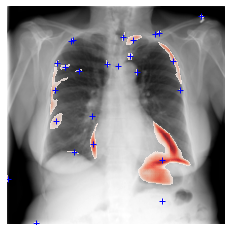

In [98]:
image = torch.from_numpy(sample["img"]).squeeze()
plt.imshow(image,cmap='gray')
plt.axis('off')
z=attribution.thresholdf(saliency_maps['latentshift-max'],95)
z[z==0]=np.nan
plt.imshow(z, interpolation='none', alpha=0.8, cmap="Reds");
comps,n_comps=smap_components['latentshift-max']
for i in range(1,n_comps+1):
    component=np.where(comps==i)
    centroid=np.mean(component, axis=1)
    plt.plot(centroid[1],centroid[0],'b+')
plt.show()

In [103]:
len(np.where(comps==8)[0])

194

tensor([0.5946])
[0.04986257] -910 160
Thresholding at 0.03180803571428571
Thresholding at 0.03180803571428571
Thresholding at 0.03180803571428571
Thresholding at 0.03180803571428571


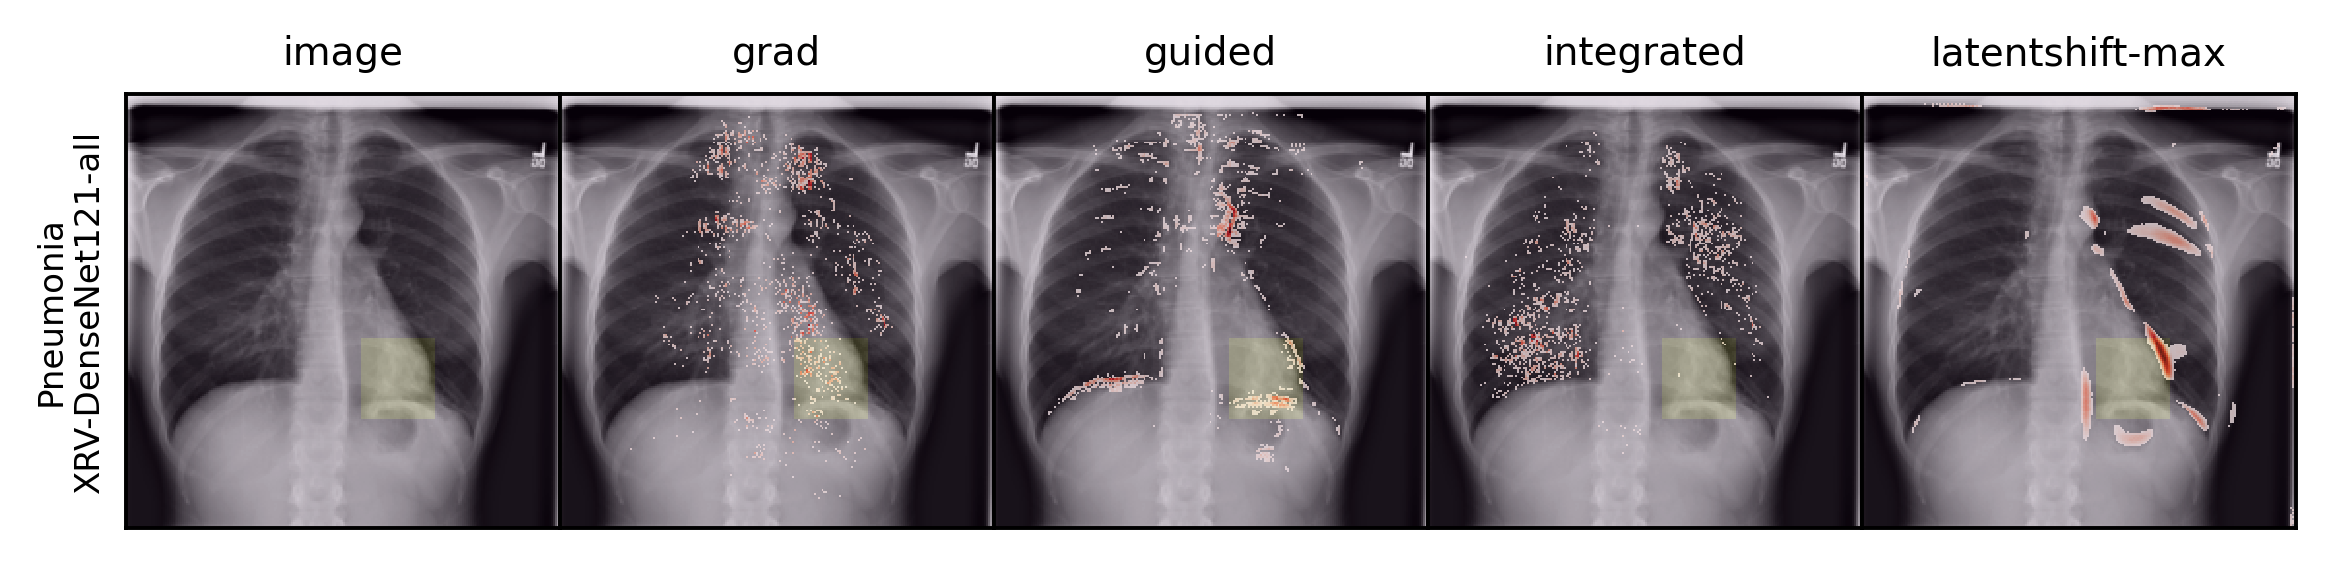

In [62]:
target = "Pneumonia"
label = 1
dwhere = np.where(dmerge.csv.has_masks & (dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
idx = 0
sample = dmerge[dwhere[idx]]
model = models[0]
_=attribution.generate_attributions(sample, model, target, ae, temp_path, dmerge)

In [61]:
for i,idx in enumerate(dwhere):
    if dmerge.pathologies.index(target) in dmerge[idx]['pathology_masks']:
        mask=dmerge[idx]['pathology_masks'][dmerge.pathologies.index(target)].squeeze()
        labeled, ncomponents=s_ndi_m.label(mask)
        print(i,idx,ncomponents)
#plt.imshow(sample['pathology_masks'][dmerge.pathologies.index(target)].squeeze())


0 4704 1
1 6832 1
2 7482 1
3 7697 1
4 8568 1
5 9820 1
6 13257 1
7 13349 1
8 13992 1
9 17389 1
10 17823 1
11 20239 1
12 21874 1
13 23640 1
14 24682 1
15 24803 1
16 25985 1
17 27163 1
18 27788 1
19 29724 1
20 31541 1
21 31782 1
22 32652 1
23 33875 1
24 34135 1
25 36143 1
26 36212 1
27 38378 1
29 43011 1
30 43218 1
31 43348 1
32 44159 1
34 49891 1
35 51257 1
36 51674 1
37 51909 1
38 52039 1
39 52440 1
40 52563 1
41 52757 1
42 52878 1
43 54397 1
44 54674 1
45 54939 1
46 55111 1
47 59008 1
48 59433 1
49 62290 1
50 63038 1
51 65760 1


In [43]:
labeled, ncomponents=s_ndi_m.label(sample['pathology_masks'][dmerge.pathologies.index(target)].squeeze().astype(np.bool))
print(ncomponents)

1
